1. Project background

Airbnb is an online marketplace for short-term home and apartment rentals. Determining the optimal nightly rent price poses a challenge for hosts. Though Airbnb offers general guidance, there are no easily accessible methods for setting the best price. Third-party software exists but can be expensive. One possible approach is to average the prices of similar listings, but this may not be accurate or account for crucial property characteristics. To address this, the project aims to propose a data-driven solution using machine learning to predict rental prices. 

The model will consider the property's feature .....


2. Datasets


The dataset used in this project is from Insideairbnb.com, an anti-Airbnb lobby group, and includes information on all Vancouver Airbnb listings from Jun, 2023. However, it has limitations, as it only provides the advertised prices, not the actual average amounts paid per night. Despite this, it serves as a proof of concept, and a more accurate version could be built using higher quality, paid data sources. 



3. Data Cleaning & Preprocessing

- We drop columns that are free-text (i.e urls) and host-related information that are irrelevant to the property's characeristics, hence not useful in price prediction
- We drop columns that contain majority of null entries (except for review related columns)


In [1]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from datetime import datetime #imported this


In [2]:
raw_df = pd.read_csv('datasets/listings.csv.gz')
print(f"Exists {len(raw_df)} Airbnb Listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # view all features
pd.set_option('display.max_rows', 100) 
raw_df.head(3) # view 

Exists 6355 Airbnb Listings


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13188,https://www.airbnb.com/rooms/13188,20230610001854,2023-06-10,city scrape,Rental unit in Vancouver · ★4.83 · Studio · 2 ...,Garden level studio suite with garden patio - ...,The uber hip Main street area is a short walk ...,https://a0.muscache.com/pictures/8408188/e1af6...,51466,https://www.airbnb.com/users/show/51466,Family Guns,2009-11-04,"Vancouver, Canada",We are a family who love to travel in comfort ...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/0b83b...,https://a0.muscache.com/im/pictures/user/0b83b...,Riley Park,2,3,"['email', 'phone']",t,t,"Vancouver, British Columbia, Canada",Riley Park,NaN,49.24773,-123.10509,Entire rental unit,Entire home/apt,4,NaN,1 bath,NaN,2.0,"[""Portable fans"", ""Refrigerator"", ""TV with sta...",$150.00,3,180,3,3,180,180,3.0,180.0,NaN,t,0,0,3,150,2023-06-10,260,4,1,2010-02-21,2023-06-01,4.83,4.87,4.84,4.86,4.91,4.88,4.80,22-156193,f,2,2,0,0,1.61
1,13358,https://www.airbnb.com/rooms/13358,20230610001854,2023-06-10,city scrape,Condo in Vancouver · ★4.68 · 1 bedroom · 1 bed...,<b>The space</b><br />This suites central loca...,NaN,https://a0.muscache.com/pictures/40034c18-0837...,52116,https://www.airbnb.com/users/show/52116,Lynn,2009-11-07,"Vancouver, Canada",I am from Vancouver and in my free time enjoy ...,within a few hours,100%,99%,t,https://a0.muscache.com/im/pictures/user/User-...,https://a0.muscache.com/im/pictures/user/User-...,Downtown Vancouver,1,1,"['email', 'phone']",t,t,NaN,West End,NaN,49.28201,-123.12669,Entire condo,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Dishwasher"", ""Free washer \u2013 In building...",$227.00,1,90,1,1,90,90,1.0,90.0,NaN,t,5,11,14,247,2023-06-10,454,19,3,2010-06-22,2023-05-22,4.68,4.76,4.80,4.84,4.80,4.92,4.67,22-311727,f,1,1,0,0,2.88
2,13490,https://www.airbnb.com/rooms/13490,20230610001854,2023-06-10,city scrape,Rental unit in Vancouver · ★4.92 · 1 bedroom ·...,This apartment rents for one month blocks of t...,"In the heart of Vancouver, this apartment has ...",https://a0.muscache.com/pictures/73394727/79d5...,52467,https://www.airbnb.com/users/show/52467,Iris,2009-11-08,"Vancouver, Canada",Hello! My husband Fred and I are actors living...,within an hour,100%,88%,t,https://a0.muscache.com/im/users/52467/profile...,https://a0.muscache.com/im/users/52467/profile...,Kensington-Cedar Cottage,3,4,"['email', 'phone']",t,t,"Vancouver, British Columbia, Canada",Kensington-Cedar Cottage,NaN,49.25622,-123.06607,Entire rental unit,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Dishwasher"", ""Lake view"", ""Window guards"", ""...",$150.00,30,180,30,30,180,180,30.0,180.0,NaN,t,2,5,5,121,2023-06-10,98,5,0,2011-06-02,2023-05-01,4.92,4.93,4.96,4.

In [3]:

cols_to_drop_1 = ['listing_url','source' ,'scrape_id', 'last_scraped', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop_1, axis=1)
pd.set_option('display.max_columns', len(raw_df.columns)) # view all features

In [4]:
df.isna().sum() # determine number of Nan entries in each columns

id                                                 0
host_since                                         0
host_response_time                              1156
host_response_rate                              1156
host_acceptance_rate                             964
host_is_superhost                               1185
host_listings_count                                0
host_total_listings_count                          0
host_has_profile_pic                               0
host_identity_verified                             0
neighbourhood                                   2134
neighbourhood_cleansed                             0
neighbourhood_group_cleansed                    6355
latitude                                           0
longitude                                          0
property_type                                      0
room_type                                          0
accommodates                                       0
bathrooms                                     

- Neighbourhood_group_cleansed, bathroom and calendar_updated are columns whose data are all null values -> drop.
- Latitude and longitude data will be processed differently (usually using Euclidian distance formula to make sense of what's nearby), and will not be as helpful as neighborhood in prediction using classification -> save to a seperate data frame for possible future use.
- There exists many columns for min and max night stays: minimum_nights and minimum_minimum_nights, and maximum_nights and maximum_maximum_nights. According to our google search, minimum_mimnimum_nights and maximum_maximum_nights refers to minimum night stay requirement that has been changed over the year. This implies that the accommodation provider might have different minimum night stay policies during different seasons or time periods. This opens an opportunity to do further work on seasonality of AirBnB listing prices. In our analysis however, minimum night and maximum night stay values will be used primarily.
- Calculated_host_listings_count for entire homes, private rooms and shared rooms will be dropped as one will be the total of the other -> redundant data -> drop. 
- Host listing count and host total listing counts refers to host listing count as of this time vs total listings annually. Just like with minimum and maximum nights, we will keep host listing count since it's the most relevant feature, and to avoid duplication.
- Neighborhood is neighborhood_cleaned but with more Nan values and contain both city and country data instead of just the neighborhood in Vancouver. Since all listings are in Vancouver, Neighborhood is less clean and creates more duplications -> Drop Neighborhood. 


In [5]:
lat_long = df[['latitude', 'longitude']]
lat_long.to_csv('datasets/lat_long_data.csv.gz', index=False, compression='gzip')
cols_to_drop_2 = ['neighbourhood_group_cleansed',
                'calendar_updated',
                'bathrooms',
                'latitude',
                'longitude',
                'minimum_minimum_nights',
                'minimum_minimum_nights',
                "maximum_minimum_nights",
                "minimum_maximum_nights",
                "maximum_maximum_nights",
                "minimum_nights_avg_ntm",
                "maximum_nights_avg_ntm",
                "calculated_host_listings_count_entire_homes",
                "calculated_host_listings_count_private_rooms",
                "calculated_host_listings_count_shared_rooms",
                "host_total_listings_count",
                'neighbourhood']
df.drop(cols_to_drop_2,axis=1,inplace=True)



- bathroom text is the text version of Bathroom (Eg. Bathroom text : 1 bath -> Bathroom : 1) -> Extract Bathroom text using Python regex and save numerical values in to a column named Bathroom.

In [6]:
df['bathroom'] = df['bathrooms_text'].str.extract(r'(?P<bathroom>\d+)').astype(float).fillna(0).astype(int)
df.drop(['bathrooms_text'], axis=1,inplace=True)
df['bathroom'].isna().any() # check to see if column bathroom has any more null values

False

- Check for the variability in number of instances in features with True/False and Categorial data. If there is only one type (For example if a boolean column only has True for value, that column should be dropped).

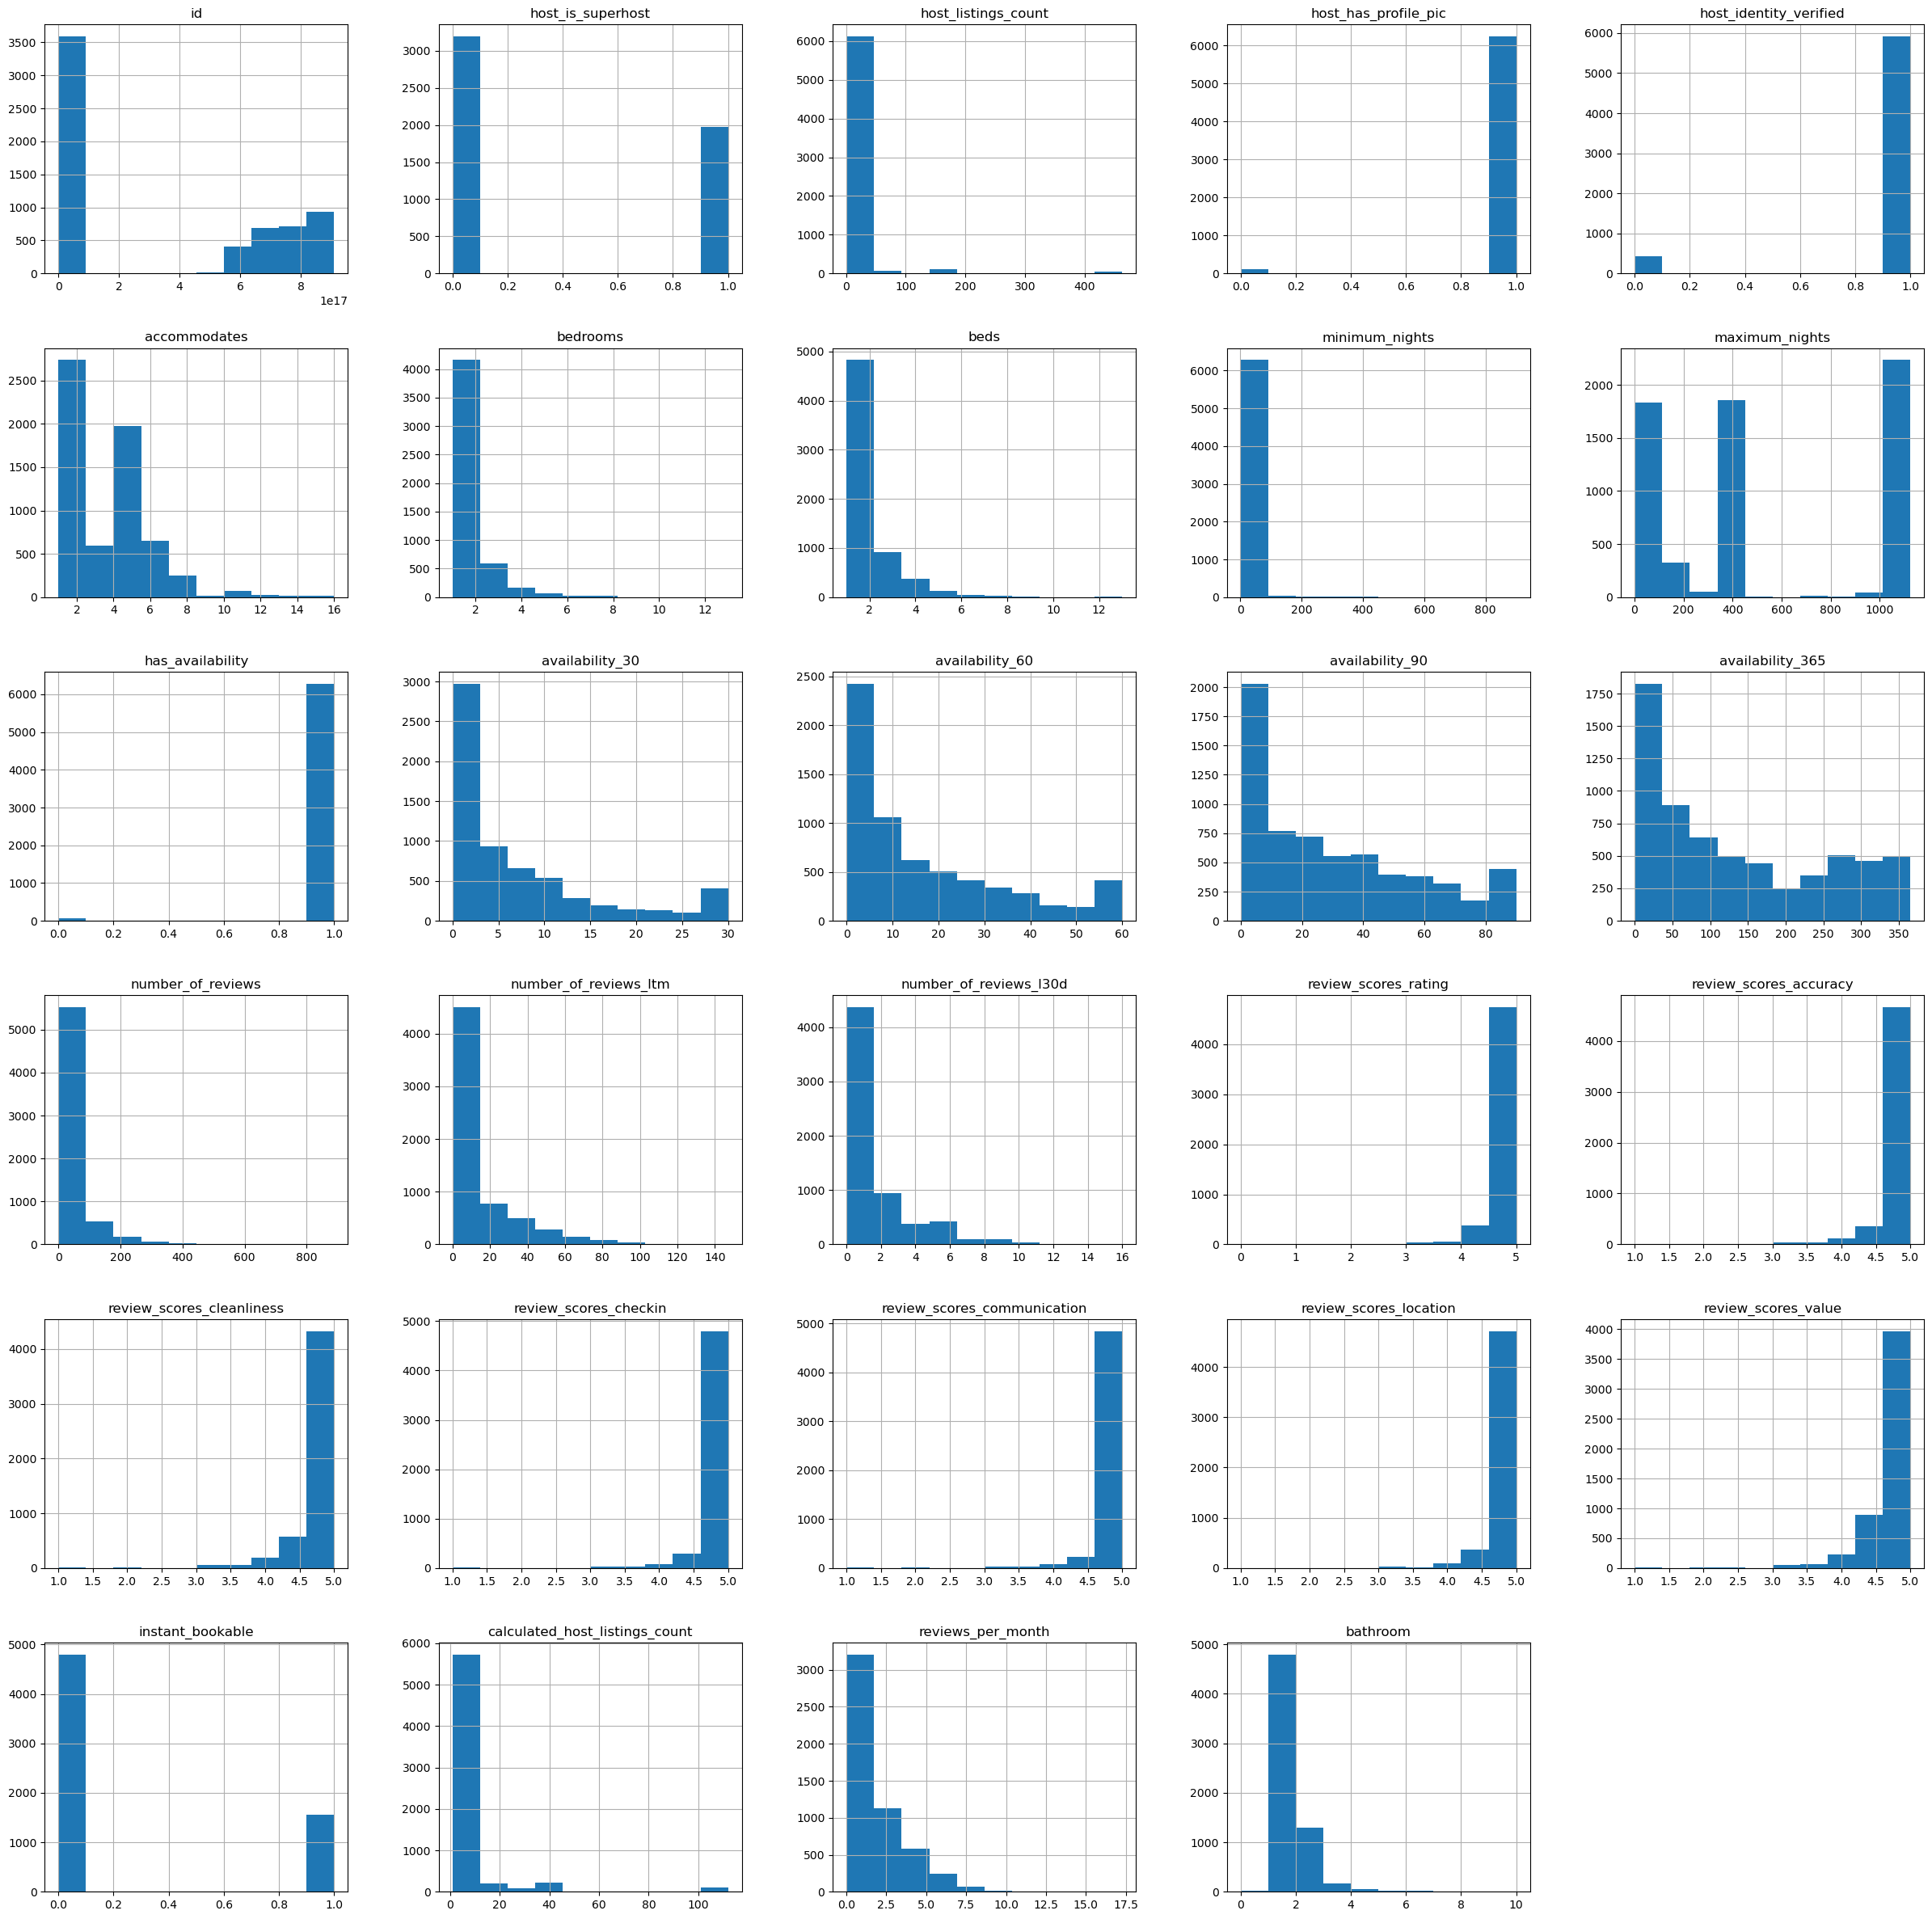

In [7]:
# Replace columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plot the distribution of numerical and boolean categories
df.hist(figsize=(30,30));

In [8]:
single_category_cols = ['has_availability', 'host_has_profile_pic']
df.drop(single_category_cols,axis=1,inplace=True)

Feature Descriptions
- host_since: date that the host first joined Airbnb
- host_response_time: average amount of time the host takes to reply to messages
- host_response_rate:  proportion of messages that the host replies to
- host_acceptance_rate: proportion of requests that the host accepts
- host_is_superhost: quality for the top-rated and most experienced hosts, and can increase your search ranking on Airbnb
- host_listings_count: how many listings host has in total
- host_identity_verified: whether or not the host has been verified with id
- neighbourhood_cleansed: Cities in Vancouver where property locates
- property_type: type of property, e.g. house or flat
- room_type: type of listing, e.g. entire home, private room or shared room
- accommodates: number of people host accommodates
bathrooms_text                       1
bedrooms                          1318
beds                                42
amenities                            0
price                                0
minimum_nights                       0
maximum_nights                       0
availability_30                      0
availability_60                      0
availability_90                      0
availability_365                     0
number_of_reviews                    0
number_of_reviews_ltm                0
number_of_reviews_l30d               0
first_review                      1107
last_review                       1107
review_scores_rating              1107
review_scores_accuracy            1121
review_scores_cleanliness         1120
review_scores_checkin             1121
review_scores_communication       1121
review_scores_location            1122
review_scores_value               1121
license                           2471
instant_bookable                     0
calculated_host_listings_count       0
reviews_per_month                 1107

In [9]:
df.isna().sum()

id                                   0
host_since                           0
host_response_time                1156
host_response_rate                1156
host_acceptance_rate               964
host_is_superhost                 1185
host_listings_count                  0
host_identity_verified               0
neighbourhood_cleansed               0
property_type                        0
room_type                            0
accommodates                         0
bedrooms                          1318
beds                                42
amenities                            0
price                                0
minimum_nights                       0
maximum_nights                       0
availability_30                      0
availability_60                      0
availability_90                      0
availability_365                     0
number_of_reviews                    0
number_of_reviews_ltm                0
number_of_reviews_l30d               0
first_review             

In [10]:
#Clean individual columns
df['host_since'] = pd.to_datetime(df['host_since']) #convert to datetime object
df['host_since'].min() # earliest date is('2009-01-05 00:00:00')

#Calculate the number of days host is active
df['host_active'] = ( df['host_since'] - pd.datetime(2009 , 1 , 5)).dt.days

#get the mean and median
median = df['host_active'].median()
print("Mean days as host :" , round(df['host_active'].mean()))
print("Median days as host :" , round (median))

#check to see if there is null values 
# print("Num of null values in host_active :" , (df['host_active'] == 0).sum())

#  Replace the zeros with the median value
df['host_active'] = df['host_active'].replace(0, median)

Mean days as host : 3049
Median days as host : 2952


/var/folders/dv/vxvm13ws3k9gyqkd49bmclcr0000gn/T/ipykernel_24889/4182756071.py:6: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  df['host_active'] = ( df['host_since'] - pd.datetime(2009 , 1 , 5)).dt.days


In [11]:
print("Null values: " , df['host_response_time'].isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")


df['host_response_time'].fillna("unknown" , inplace = True)
df['host_response_time'].value_counts()

Null values:  1156
Proportion: 18.2%


within an hour        3870
unknown               1156
within a few hours     806
within a day           398
a few days or more     125
Name: host_response_time, dtype: int64

In [12]:
 # Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')

print("Mean host response rate:", round(df['host_response_rate'].mean(),0))
print("Median host response rate:", df['host_response_rate'].median())
print(f"Proportion of 100% host response rates: {round(((df.host_response_rate == 100.0).sum()/df.host_response_rate.count())*100,1)}%")

Mean host response rate: 96.0
Median host response rate: 100.0
Proportion of 100% host response rates: 82.6%


In [13]:
# Bin into four categories
bins = [0, 50, 90, 99, 100]
labels = ['0-49%', '50-89%', '90-99%', '100%']
df.host_response_rate = pd.cut(df.host_response_rate, 
                               bins= bins, 
                               labels= labels, 
                               include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts(normalize = True)

100%       0.675846
unknown    0.181904
50-89%     0.062156
90-99%     0.056019
0-49%      0.024076
Name: host_response_rate, dtype: float64

In [14]:
df['host_acceptance_rate'] = df['host_acceptance_rate'].str.replace('%', '').astype(np.float64)

# Define bins and labels here
bins = [0, 50, 90, 99, 100]
labels = ['0-49%', '50-89%', '90-99%', '100%']

df['host_acceptance_rate'] = pd.cut(df['host_acceptance_rate'], 
                                    bins=bins, 
                                    labels=labels, 
                                    include_lowest=True)
df['host_acceptance_rate'].value_counts()


100%      2445
90-99%    1623
50-89%     923
0-49%      400
Name: host_acceptance_rate, dtype: int64

In [15]:
df['property_type'].value_counts() 

Entire condo                          1443
Entire rental unit                    1416
Entire home                           1177
Private room in home                   736
Entire guest suite                     663
Entire loft                            151
Private room in rental unit            129
Entire townhouse                       113
Entire guesthouse                       97
Private room in condo                   84
Entire serviced apartment               67
Private room in villa                   47
Private room in guest suite             35
Private room in townhouse               25
Entire villa                            21
Room in boutique hotel                  20
Private room in bed and breakfast       10
Tiny home                                9
Shared room in rental unit               9
Entire place                             9
Entire bungalow                          8
Private room in guesthouse               7
Entire vacation home                     6
Room in apa

In [16]:
property_type_mapping = {
    'Entire condo': 'Entire Accommodation',
    'Entire rental unit': 'Entire Accommodation',
    'Entire home': 'Entire Accommodation',
    'Private room in home': 'Private Room',
    'Entire guest suite': 'Entire Accommodation',
    'Entire loft': 'Entire Accommodation',
    'Private room in rental unit': 'Private Room',
    'Entire townhouse': 'Entire Accommodation',
    'Entire guesthouse': 'Entire Accommodation',
    'Private room in condo': 'Private Room',
    'Entire serviced apartment': 'Entire Accommodation',
    # Add more mappings for other property types as needed
}

# Use the map function to create a new column with the assigned categories
df['property_type_category'] = df['property_type'].map(property_type_mapping)

# Check the value counts of the new property_type_category column
print(df['property_type_category'].value_counts())

Entire Accommodation    5127
Private Room             949
Name: property_type_category, dtype: int64


In [17]:
cols = ['beds' , 'bedrooms' , 'bathroom']
df.loc[:, cols] = df[cols].fillna(df[cols].median())
 

room_type 

Since the accomodation type is categorized and almost all the room type are similar , so this feature will not be useful

In [18]:
df.room_type.value_counts()


Entire home/apt    5207
Private room       1122
Shared room          23
Hotel room            3
Name: room_type, dtype: int64

In [19]:
df.drop('room_type' , axis = 1 , inplace = True)
df.amenities

0       ["Portable fans", "Refrigerator", "TV with sta...
1       ["Dishwasher", "Free washer \u2013 In building...
2       ["Dishwasher", "Lake view", "Window guards", "...
3       ["Refrigerator", "Fire extinguisher", "Heating...
4       ["Dishwasher", "Portable fans", "Refrigerator"...
                              ...                        
6350    ["Paid parking on premises", "TV", "Free parki...
6351    ["TV", "Free parking on premises", "Fire extin...
6352    ["Dishwasher", "Refrigerator", "Heating", "Fre...
6353    ["Shampoo", "Free parking on premises", "First...
6354    ["TV", "Exercise equipment", "Pool", "First ai...
Name: amenities, Length: 6355, dtype: object

In [20]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
# amenities_set

In the list above, some amenities are more important than others and some are likely to be fairly uncommon. In this project, amenities will be based on quick research into which amenities are considered by guests as shown on Airbnb webpage.

In [21]:
popular_am = ['Air conditioning' , 'Heating' , 'TV' , 'Refrigerator' , 'Hair Dryer' , 'Dish Washer' , 'Gym' ,
             'Kitchen', 'Internet/Wifi']
 
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Heater|Heating|heater|heating'), 'Heating'] = 1
df.loc[df['amenities'].str.contains('TV|Cable TV'), 'TV'] = 1 
df.loc[df['amenities'].str.contains('refrigerator|Refrigerator'), 'Refigerator'] = 1 
df.loc[df['amenities'].str.contains('Hair Dryer|dryer'), 'Hair Dryer'] = 1 
df.loc[df['amenities'].str.contains('Dish Washer | dish washer'), 'Dish Washer'] = 1 
df.loc[df['amenities'].str.contains('Kitchen | kitchen'), 'Kitchen'] = 1
df.loc[df['amenities'].str.contains('Internet/Wifi'), 'Internet/Wifi'] = 1

df

,id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_identity_verified,neighbourhood_cleansed,property_type,accommodates,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,reviews_per_month,bathroom,host_active,property_type_category,air_conditioning,Heating,TV,Refigerator,Hair Dryer,Dish Washer,Kitchen,Internet/Wifi
0,13188,2009-11-04,within an hour,100%,100%,1.0,2,1,Riley Park,Entire rental unit,4,2.0,2.0,"[""Portable fans"", ""Refrigerator"", ""TV with sta...",$150.00,3,180,0,0,3,150,260,4,1,2010-02-21,2023-06-01,4.83,4.87,4.84,4.86,4.91,4.88,4.80,22-156193,0,2,1.61,1,303,Entire Accommodation,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN
1,13358,2009-11-07,within a few hours,100%,90-99%,1.0,1,1,West End,Entire condo,2,1.0,1.0,"[""Dishwasher"", ""Free washer \u2013 In building...",$227.00,1,90,5,11,14,247,454,19,3,2010-06-22,2023-05-22,4.68,4.76,4.80,4.84,4.80,4.92,4.67,22-311727,0,1,2.88,1,306,Entire Accommodation,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
2,13490,2009-11-08,within an hour,100%,50-89%,1.0,3,1,Kensington-Cedar Cottage,Entire rental unit,2,1.0,1.0,"[""Dishwasher"", ""Lake view"", ""Window guards"", ""...",$150.00,30,180,2,5,5,121,98,5,0,2011-06-02,2023-05-01,4.92,4.93,4.96,4.96,4.97,4.78,4.89,NaN,0,1,0.67,1,307,Entire Accommodation,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN
3,14267,2009-11-20,unknown,unknown,NaN,0.0,1,1,Kensington-Cedar Cottage,Entire home,4,1.0,2.0,"[""Refrigerator"", ""Fire extinguisher"", ""Heating...",$150.00,3,7,0,0,0,0,34,0,0,2010-10-03,2021-07-14,4.76,4.84,4.68,4.90,4.68,4.77,4.71,21-156500,1,1,0.22,1,319,Entire Accommodation,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN
4,14424,2009-11-23,within a few hours,100%,50-89%,0.0,4,1,Downtown Eastside,Entire guest suite,2,1.0,1.0,"[""Dishwasher"", ""Portable fans"", ""Refrigerator""...",$134.00,30,1125,0,3,8,187,266,7,1,2010-02-15,2023-05-25,4.69,4.84,4.93,4.85,4.72,4.60,4.74,19-162091,0,4,1.64,1,322,Entire Accommodation,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6350,909441856435440521,2022-08-09,within an hour,90-99%,100%,NaN,16,1,Downtown,Entire rental unit,4,2.0,2.0,"[""Paid parking on premises"", ""TV"", ""Free parki...",$500.00,5,365,30,60,90,364,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22-765489,0,16,NaN,2,4964,Entire Accommodation,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6351,909449559503146188,2016-07-06,unknown,unknown,NaN,0.0,1,1,Shaughnessy,Private room in home,2,1.0,1.0,"[""TV"", ""Free parking on premises"", ""Fire extin...",$44.00,30,365,30,60,90,179,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,NaN,1,2739,Private Room,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6352,909475142117498102,2018-11-26,within an hour,100%,100%,0.0,144,1,Mount Pleasant,Entire rental unit,2,1.0,1.0,"[""Dishwasher"", ""Refrigerator"", ""Heating"", ""Fre...",$82.00,30,365,30,60,90,363,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,112,NaN,1,3612,Entire Accommodation,NaN,1.0,1.0,1.0,1.0,NaN,NaN,NaN
6353,909538682993188639,2015-04-11,unknown,unknown,NaN,0.0,2,1,Kerrisdale,Private room in home,1,1.0,1.0,"[""Shampoo"", ""Free parking on premises"", ""First...",$45.00,1,365,15,45,68,106,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23-238530,0,2,NaN,1,2287,Private Room,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = df.iloc[:,40:].columns
df[cols_to_replace_nulls] = df[cols_to_replace_nulls].fillna(0)

# create a list of anemities with less frequencies (< 10%)
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['Dish Washer', 'Kitchen', 'Internet/Wifi']


Price

Price will be converted to float value and the extra white space will be removed

In [23]:
df['price'] = df['price'].str.replace("," , " ")
df['price'] = df['price'].str.replace(r'[^\d.]', '', regex=True).astype('float64')
 

Availability 

There are several 'availability' features but only 'Availabilityt 90' will be kept because it has the most  impact on the property's price.  

In [24]:
df.drop(['availability_30', 'availability_60', 'availability_365'], axis=1, inplace=True)

In [25]:
df.columns

Index(['id', 'host_since', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_listings_count',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights', 'availability_90', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'license', 'instant_bookable',
       'calculated_host_listings_count', 'reviews_per_month', 'bathroom',
       'host_active', 'property_type_category', 'air_conditioning', 'Heating',
       'TV', 'Refigerator', 'Hair Dryer'],
      dtype='object')

first_review and last_review

A large propotion of first and last review are NaN value but it doesn't seem appropriate to replace them with median/mean values becuase this will skew the distribution.Also , the missing values in fact means that the listings are new or previously unbooked listings that doesnt have reviews yet.So , the solution we came up is to categorize them as an unknown category.
 



Null values in 'first_review': 17.4%
Null values in 'review_scores_rating': 17.4%


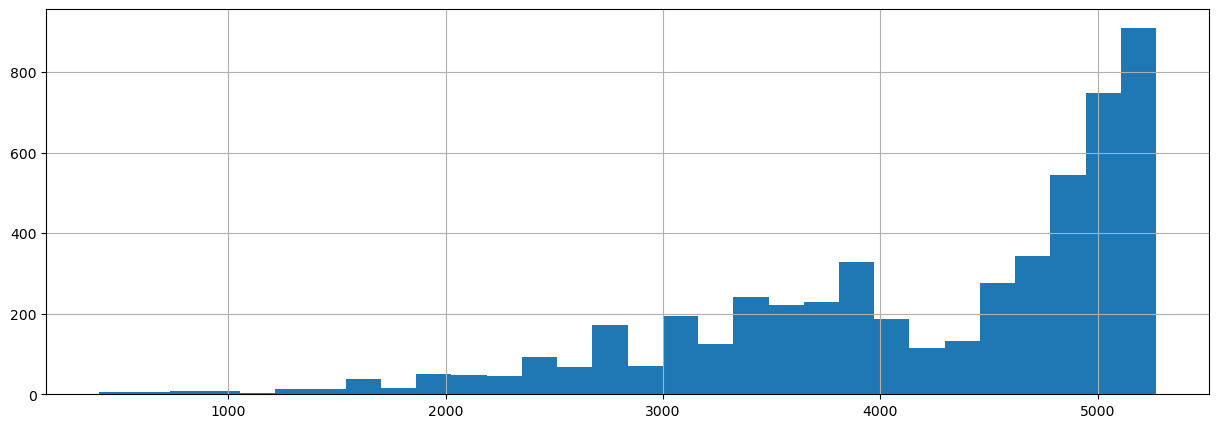

In [26]:
print(f"Null values in 'first_review': {round(100*df.first_review.isna().sum()/len(df),1)}%")
print(f"Null values in 'review_scores_rating': {round(100*df.review_scores_rating.isna().sum()/len(df),1)}%")

# Converting 'first_review' to datetime
df.first_review = pd.to_datetime(df.first_review)

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (df.first_review - pd.Timestamp('2009-01-05')).dt.days
 

# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15, 5), bins=30)

bins_first_review = [0, 182, 365, 730, 1460, df['time_since_first_review'].max()]
labels_first_review = ['0-6 months', '6-12 months', '1-2 years', '2-3 years', '4+ years']
df['time_since_first_review'] = pd.cut(df['time_since_first_review'], bins=bins_first_review, labels=labels_first_review, include_lowest=True)
df['time_since_first_review'] = df['time_since_first_review'].astype('str')
df['time_since_first_review'].fillna('no reviews', inplace=True)



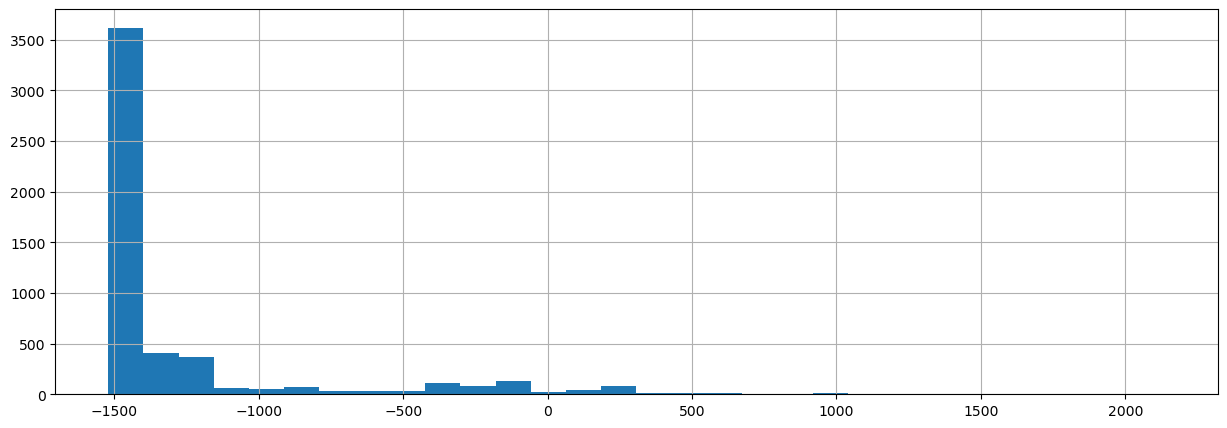

In [27]:
# Convert 'last_review' column to datetime
df['last_review'] = pd.to_datetime(df['last_review'])

# Calculate the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (pd.Timestamp('2019-04-09') - df['last_review']).dt.days

# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15, 5), bins=30)

# Binning time since last review
bins_last_review = [0, 14, 60, 182, 365, df['time_since_last_review'].max()]
labels_last_review = ['0-2 weeks', '2-8 weeks', '2-6 months', '6-12 months', '1+ year']
df['time_since_last_review'] = pd.cut(df['time_since_last_review'], bins=bins_last_review, labels=labels_last_review, include_lowest=True)
df['time_since_last_review'] = df['time_since_last_review'].astype('str')
df['time_since_last_review'].fillna('no reviews', inplace=True)

# Dropping the original 'last_review' column
df.drop('last_review', axis=1, inplace=True)



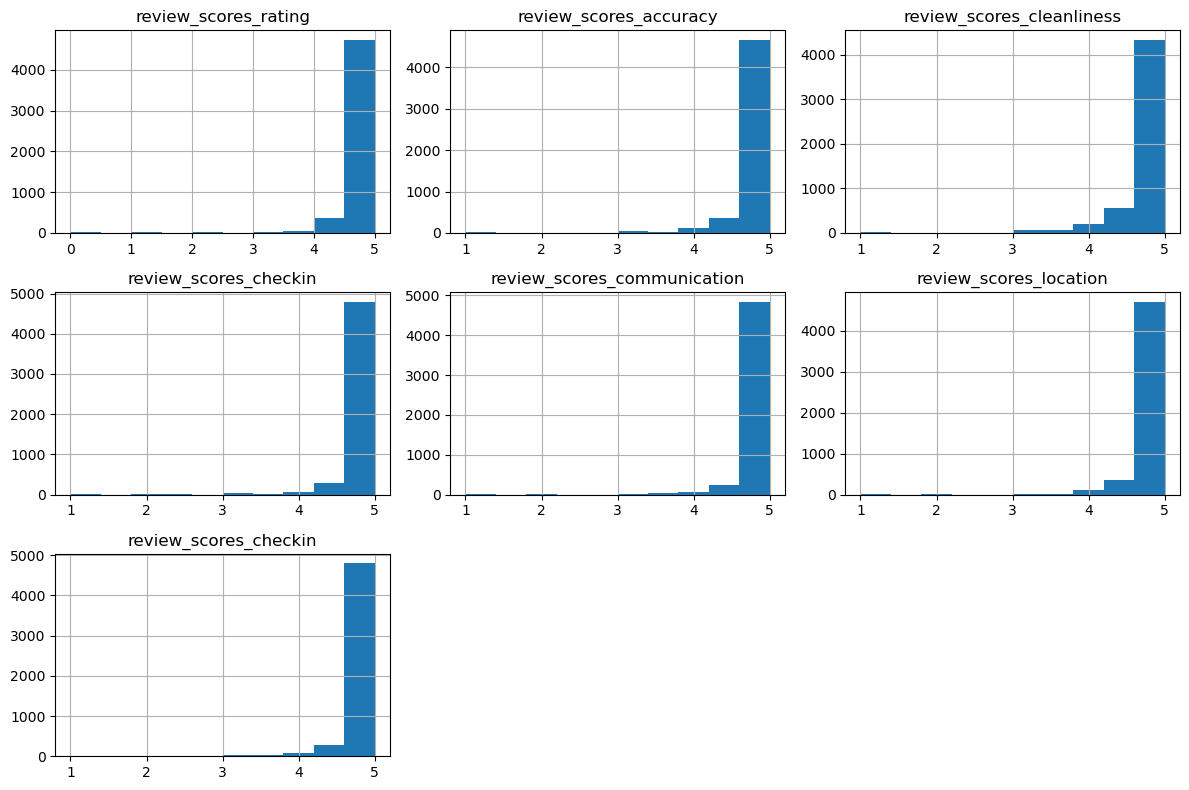

In [28]:
plot = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 
        'review_scores_checkin']

fig = plt.figure(figsize=(12, 8))
for i, var_name in enumerate(plot, 1):
    ax = fig.add_subplot(3, 3, i)
    df[var_name].hist(bins=10, ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

del plot[0]
 

#the plot seems okay so I'll just leave it

In [29]:
# Binning for all columns scored out of 10
 
# Define the rating bins and labels
rating_bins = [0, 3, 5, 8 , 10]
rating_labels = ['0-3/10', '3-5/10', '5-18/10' , '8-10/10']

# Categorize the 'review_scores_checkin' column
df['review_scores_checkin'] = pd.cut(df['review_scores_checkin'], bins=rating_bins, labels=rating_labels, include_lowest=True)

print(df['review_scores_checkin'].value_counts())

3-5/10     5191
0-3/10       43
5-18/10       0
8-10/10       0
Name: review_scores_checkin, dtype: int64


In [30]:
 # Define the rating bins and labels
rating_bins = [0, 30, 70, 90 , 100]
rating_labels = ['0-30/100', '50-70/100', '70-90/100' , '90-100/100']

# Categorize the 'review_scores_rating' column
df['review_scores_rating'] = pd.cut(df['review_scores_rating'], bins=rating_bins, labels=rating_labels, include_lowest=True)

print(df['review_scores_rating'].value_counts())

#not sure if i should keep this because they are all in one category

0-30/100      5248
50-70/100        0
70-90/100        0
90-100/100       0
Name: review_scores_rating, dtype: int64


In [36]:
cleaned_data = df.to_csv('datasets/cleaned_listing_data.gz', index=False, compression='gzip')